# Deep Reinforcement Learning Laboratory

In this laboratory session we will work on getting more advanced versions of Deep Reinforcement Learning algorithms up and running. Deep Reinforcement Learning is **hard**, and getting agents to stably train can be frustrating and requires quite a bit of subtlety in analysis of intermediate results. We will start by refactoring (a bit) my implementation of `REINFORCE` on the [Cartpole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/). 

## Exercise 1: Improving my `REINFORCE` Implementation (warm up)

In this exercise we will refactor a bit and improve some aspects of my `REINFORCE` implementation. 

**First Things First**: Spend some time playing with the environment to make sure you understand how it works.

### 1.1 – Esplorazione dell’ambiente CartPole

- `env.reset()` fornisce uno stato iniziale, che consiste in un vettore continuo con 4 elementi: posizione e velocità, sia del carrello che dell’asta.
- `observation_space` è un box continuo di dimensione 4.
- `action_space` è discreto e permette di compiere 2 azioni (spostare il carrello verso destra o verso sinistra).


In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import Categorical
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
# Instantiate a rendering and a non-rendering environment.
env_render = gym.make('CartPole-v1', render_mode='human')
env = gym.make('CartPole-v1')

/var/folders/cy/nmg8_p0n0jl67kvqh6fp_6f80000gn/T/ipykernel_25078/3631391549.py:9: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not hasattr(np, 'bool8'):


In [2]:
class PolicyNet(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], 128)
        self.fc2 = nn.Linear(128, env.action_space.n)
        
    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = F.softmax(self.fc2(s), dim=-1)
        return s


In [3]:
# Given an environment, observation, and policy, sample from pi(a | obs). Returns the
# selected action and the log probability of that action (needed for policy gradient).
def select_action(env, obs, policy):
    dist = Categorical(policy(obs))
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return (action.item(), log_prob.reshape(1))

# Utility to compute the discounted total reward. Torch doesn't like flipped arrays, so we need to
# .copy() the final numpy array. There's probably a better way to do this.
def compute_returns(rewards, gamma):
    return np.flip(np.cumsum([gamma**(i+1)*r for (i, r) in enumerate(rewards)][::-1]), 0).copy()

# Given an environment and a policy, run it up to the maximum number of steps.
def run_episode(env, policy, maxlen=500):
    # Collect just about everything.
    observations = []
    actions = []
    log_probs = []
    rewards = []
    
    # Reset the environment and start the episode.
    (obs, info) = env.reset()
    for i in range(maxlen):
        # Get the current observation, run the policy and select an action.
        obs = torch.tensor(obs)
        (action, log_prob) = select_action(env, obs, policy)
        observations.append(obs)
        actions.append(action)
        log_probs.append(log_prob)
        
        # Advance the episode by executing the selected action.
        (obs, reward, term, trunc, info) = env.step(action)
        rewards.append(reward)
        if term or trunc:
            break
    return (observations, actions, torch.cat(log_probs), rewards)

In [4]:
# A direct, inefficient, and probably buggy of the REINFORCE policy gradient algorithm.
def reinforce(policy, env, env_render=None, gamma=0.99, num_episodes=10):
    # The only non-vanilla part: we use Adam instead of SGD.
    opt = torch.optim.Adam(policy.parameters(), lr=1e-2)

    # Track episode rewards in a list.
    running_rewards = [0.0]
    
    # The main training loop.
    policy.train()
    for episode in range(num_episodes):
        # Run an episode of the environment, collect everything needed for policy update.
        (observations, actions, log_probs, rewards) = run_episode(env, policy)
        
        # Compute the discounted reward for every step of the episode. 
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        
        # Keep a running average of total discounted rewards for the whole episode.
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])
        
        # Standardize returns.
        returns = (returns - returns.mean()) / returns.std()
        
        # Make an optimization step
        opt.zero_grad()
        loss = (-log_probs * returns).mean()
        loss.backward()
        opt.step()
        
        # Render an episode after every 100 policy updates.
        if not episode % 100:
            if env_render:
                policy.eval()
                run_episode(env_render, policy)
                policy.train()
            print(f'Running reward: {running_rewards[-1]}')
    
    # Return the running rewards.
    policy.eval()
    return running_rewards

In [5]:
import gymnasium as gym

# Crea l'ambiente
env = gym.make("CartPole-v1")

# Resetta l'ambiente e osserva lo stato iniziale
obs, info = env.reset()
print("Osservazione iniziale (obs):", obs)
print("Info extra:", info)

# Mostra lo spazio delle osservazioni e delle azioni
print("Spazio delle osservazioni:", env.observation_space)
print("Spazio delle azioni:", env.action_space)

# Chiudi l'ambiente
env.close()


Osservazione iniziale (obs): [-0.03864139 -0.0472291  -0.03627328 -0.0057147 ]
Info extra: {}
Spazio delle osservazioni: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Spazio delle azioni: Discrete(2)


**Next Things Next**: Now get your `REINFORCE` implementation working on the environment. You can import my (probably buggy and definitely inefficient) implementation here. Or even better, refactor an implementation into a separate package from which you can `import` the stuff you need here. 

### 1.2 – Addestramento dell’agente con il *reinforce algorithm*

L'agente è rappresentato dalla rete `PolicyNet`, che produce una distribuzione di probabilità sulle azioni da intraprendere in ogni stato.

Come è possibile osservare nel grafico che segue, l’agente impara a mantenere il palo in equilibrio dopo circa 300-400 episodi.


/var/folders/cy/nmg8_p0n0jl67kvqh6fp_6f80000gn/T/ipykernel_25078/3153814923.py:6: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not hasattr(np, 'bool8'):
/opt/anaconda3/envs/DRL310/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Running reward: 2.0148160934448245
Running reward: 80.80246261736822
Running reward: 97.38190612140778
Running reward: 97.22565321448555
Running reward: 94.68051293588019


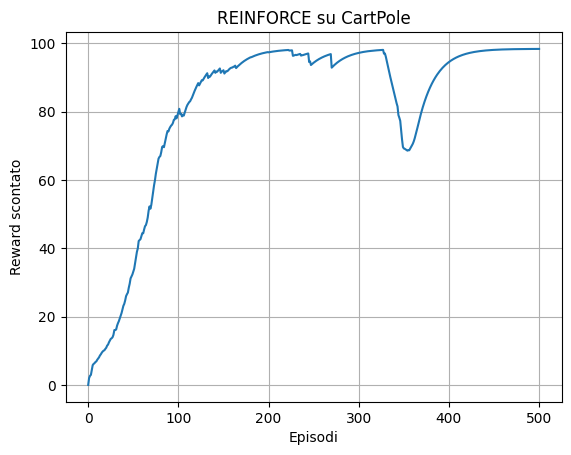

In [6]:
import torch
import matplotlib.pyplot as plt
import gymnasium as gym
import pygame
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

# Fissa il seed per la riproducibilità
seed = 2112
torch.manual_seed(seed)
np.random.seed(seed)

# Inizializza l'ambiente senza rendering (più veloce)
env = gym.make('CartPole-v1')
env.reset(seed=seed)

# Inizializza la policy
policy = PolicyNet(env)

# Allena l'agente
rewards = reinforce(policy, env, env_render=None, num_episodes=500)

# Mostra l'andamento del reward
plt.plot(rewards)
plt.xlabel("Episodi")
plt.ylabel("Reward scontato")
plt.title("REINFORCE su CartPole")
plt.grid(True)
plt.show()

# Chiudi l'ambiente
env.close()


**Last Things Last**: My implementation does a **super crappy** job of evaluating the agent performance during training. The running average is not a very good metric. Modify my implementation so that every $N$ iterations (make $N$ an argument to the training function) the agent is run for $M$ episodes in the environment. Collect and return: (1) The average **total** reward received over the $M$ iterations; and (2) the average episode length. Analyze the performance of your agents with these new metrics.

## 1.3 - Valutazione dell'agente ogni N episodi

Ogni `eval_every = N` episodi l’agente viene testato per `eval_episodes = M` episodi, calcolando e salvando:
1) la **reward totale media** sui M episodi;
2) la **durata media** dell’episodio.

**Risultati**
- Fino a ~Ep 350 l’agente è **saturato a 500**, poi si osserva un **drop marcato** (≈300–335). Questo può dipendere da:
  - **Esplorazione in fase di valutazione**: se `select_action` campiona dalla politica, anche in `eval()` introduce rumore. In valutazione conviene usare azione **greedy/argmax** e disabilitare la stochasticità.
  - **Learning rate** relativamente alto (`1e-2`) → possibili oscillazioni o “catastrophic forgetting” tardi nell’allenamento.
  - **Assenza di baseline** (solo REINFORCE) → alta varianza dell’aggiornamento; l’andamento può degradare dopo molte iterazioni.

Nel complesso l’implementazione centra l’obiettivo: rende la valutazione delle sole medie mobili **periodica e più affidabile**; il grafico mette in evidenza una regressione tardiva.

In [7]:
def reinforce(policy, env, env_render=None, gamma=0.99, num_episodes=1000, 
              eval_every=50, eval_episodes=10):
    opt = torch.optim.Adam(policy.parameters(), lr=1e-2)

    running_rewards = [0.0]
    eval_avg_rewards = []
    eval_avg_lengths = []

    policy.train()
    for episode in range(num_episodes):
        # 1. Esegui episodio
        (observations, actions, log_probs, rewards) = run_episode(env, policy)

        # 2. Calcola returns scontati
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])

        # 3. Standardizza returns
        if returns.std() > 1e-6:
            returns = (returns - returns.mean()) / returns.std()

        # 4. Aggiorna policy
        opt.zero_grad()
        loss = (-log_probs * returns).mean()
        loss.backward()
        opt.step()

        # 5. Valutazione ogni eval_every episodi
        if (episode + 1) % eval_every == 0:
            policy.eval()
            total_rewards = []
            lengths = []
            for _ in range(eval_episodes):
                obs, _ = env.reset()
                done = False
                total_reward = 0
                t = 0
                while not done:
                    obs = torch.tensor(obs, dtype=torch.float32)
                    action, _ = select_action(env, obs, policy)
                    obs, reward, term, trunc, _ = env.step(action)
                    total_reward += reward
                    t += 1
                    done = term or trunc
                total_rewards.append(total_reward)
                lengths.append(t)
            avg_reward = np.mean(total_rewards) #quanto è bravo l'agente in media 
            avg_length = np.mean(lengths) #quanto a lungo riesce a mantenere il palo in equilibrio
            eval_avg_rewards.append(avg_reward)
            eval_avg_lengths.append(avg_length)
            print(f"[Ep {episode+1}] Valutazione: reward medio = {avg_reward:.1f}, durata media = {avg_length:.1f}")
            policy.train()

    return running_rewards, eval_avg_rewards, eval_avg_lengths


[Ep 50] Valutazione: reward medio = 500.0, durata media = 500.0
[Ep 100] Valutazione: reward medio = 500.0, durata media = 500.0
[Ep 150] Valutazione: reward medio = 500.0, durata media = 500.0
[Ep 200] Valutazione: reward medio = 500.0, durata media = 500.0
[Ep 250] Valutazione: reward medio = 500.0, durata media = 500.0
[Ep 300] Valutazione: reward medio = 500.0, durata media = 500.0
[Ep 350] Valutazione: reward medio = 500.0, durata media = 500.0
[Ep 400] Valutazione: reward medio = 302.4, durata media = 302.4
[Ep 450] Valutazione: reward medio = 335.5, durata media = 335.5
[Ep 500] Valutazione: reward medio = 294.7, durata media = 294.7


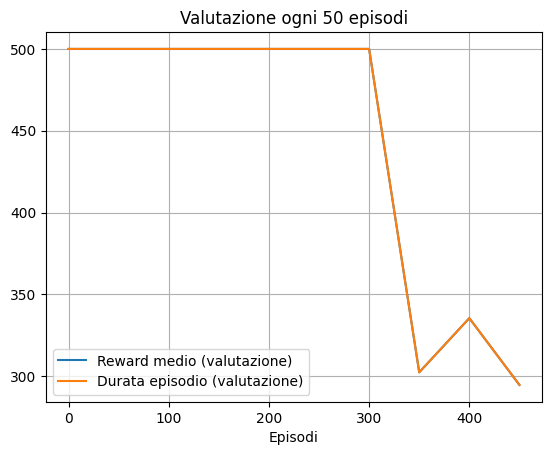

In [8]:
# Allena l'agente con valutazione ogni 50 episodi su 10 episodi
train_rewards, eval_rewards, eval_lengths = reinforce(
    policy, env, env_render=None, num_episodes=500, eval_every=50, eval_episodes=10
)

# Plot valutazioni
plt.plot(np.arange(len(eval_rewards)) * 50, eval_rewards, label="Reward medio (valutazione)")
plt.plot(np.arange(len(eval_lengths)) * 50, eval_lengths, label="Durata episodio (valutazione)")
plt.xlabel("Episodi")
plt.title("Valutazione ogni 50 episodi")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
torch.save(policy.state_dict(), "policy_cartpole.pt")


In [ ]:
env_render = gym.make('CartPole-v1', render_mode='human')
policy.eval()
run_episode(env_render, policy)
env_render.close()


2025-04-07 15:34:43.800 python[25026:850317] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-07 15:34:43.800 python[25026:850317] +[IMKInputSession subclass]: chose IMKInputSession_Modern
/opt/anaconda3/envs/DRL310/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


: 

-----
## Exercise 2: `REINFORCE` with a Value Baseline (warm up)

In this exercise we will augment my implementation (or your own) of `REINFORCE` to subtract a baseline from the target in the update equation in order to stabilize (and hopefully speed-up) convergence. For now we will stick to the Cartpole environment.




In questa versione, invece di usare una baseline costante o globale, è stata allenata una rete `ValueNet` per stimare il valore atteso di ogni stato \( V(s) \).

è stata quindi aggiornata la policy in base al **vantaggio**

- La convergenza è più stabile
- L’allenamento della baseline fornisce un feedback più preciso che riduce la varianza


In [11]:
class ValueNet(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, s):
        s = F.relu(self.fc1(s))
        return self.fc2(s)  # Output scalare (stimato V(s))


In [12]:
def reinforce_with_baseline(policy, value_net, env, env_render=None,
                            gamma=0.99, num_episodes=500, eval_every=50, eval_episodes=10):
    opt_policy = torch.optim.Adam(policy.parameters(), lr=1e-2)
    opt_value = torch.optim.Adam(value_net.parameters(), lr=1e-2)

    running_rewards = [0.0]
    eval_avg_rewards = []
    eval_avg_lengths = []

    policy.train()
    value_net.train()

    for episode in range(num_episodes):
        observations, actions, log_probs, rewards = run_episode(env, policy)

        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])

        obs_tensor = torch.stack(observations)
        baseline = value_net(obs_tensor).squeeze()
        advantages = returns - baseline.detach()

        # Calcola le distribuzioni di probabilità
        action_probs = policy(obs_tensor)
        entropy = -torch.sum(action_probs * torch.log(action_probs + 1e-8), dim=1).mean()

        # Loss della policy con entropia
        loss_policy = (-log_probs * advantages).mean() - 0.01 * entropy
        # Loss per la rete del valore (regressione MSE)
        loss_value = F.mse_loss(baseline, returns)

        # Ottimizzazione policy
        opt_policy.zero_grad()
        loss_policy.backward()
        opt_policy.step()

        # Ottimizzazione baseline
        opt_value.zero_grad()
        loss_value.backward()
        opt_value.step()

        # Valutazione
        if (episode + 1) % eval_every == 0:
            policy.eval()
            total_rewards = []
            lengths = []
            for _ in range(eval_episodes):
                obs, _ = env.reset()
                done = False
                total_reward = 0
                t = 0
                while not done:
                    obs_tensor = torch.tensor(obs, dtype=torch.float32)
                    action, _ = select_action(env, obs_tensor, policy)
                    obs, reward, term, trunc, _ = env.step(action)
                    total_reward += reward
                    t += 1
                    done = term or trunc
                total_rewards.append(total_reward)
                lengths.append(t)
            eval_avg_rewards.append(np.mean(total_rewards))
            eval_avg_lengths.append(np.mean(lengths))
            print(f"[Ep {episode+1}] Reward medio: {eval_avg_rewards[-1]:.1f}, Lunghezza media: {eval_avg_lengths[-1]:.1f}")
            policy.train()

    return running_rewards, eval_avg_rewards, eval_avg_lengths


In [13]:
policy = PolicyNet(env)
value_net = ValueNet(env)

train_rewards, eval_rewards, eval_lengths = reinforce_with_baseline(
    policy, value_net, env,
    num_episodes=500, eval_every=50, eval_episodes=10
)


[Ep 50] Reward medio: 63.8, Lunghezza media: 63.8
[Ep 100] Reward medio: 195.3, Lunghezza media: 195.3
[Ep 150] Reward medio: 272.0, Lunghezza media: 272.0
[Ep 200] Reward medio: 460.8, Lunghezza media: 460.8
[Ep 250] Reward medio: 179.1, Lunghezza media: 179.1
[Ep 300] Reward medio: 110.9, Lunghezza media: 110.9
[Ep 350] Reward medio: 231.3, Lunghezza media: 231.3
[Ep 400] Reward medio: 68.2, Lunghezza media: 68.2
[Ep 450] Reward medio: 468.1, Lunghezza media: 468.1
[Ep 500] Reward medio: 500.0, Lunghezza media: 500.0


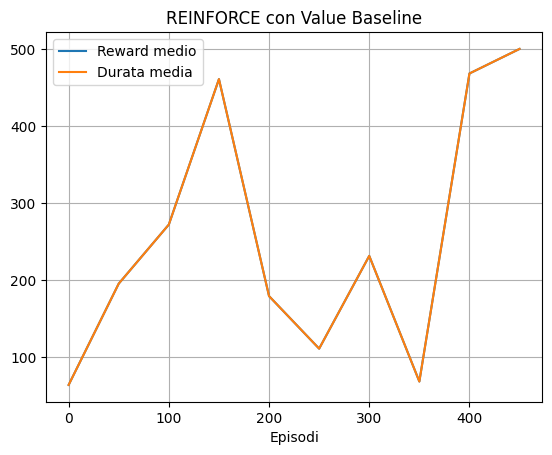

In [14]:
plt.plot(np.arange(len(eval_rewards)) * 50, eval_rewards, label="Reward medio")
plt.plot(np.arange(len(eval_lengths)) * 50, eval_lengths, label="Durata media")
plt.xlabel("Episodi")
plt.title("REINFORCE con Value Baseline")
plt.grid(True)
plt.legend()
plt.show()


### Risultati REINFORCE con Value Baseline

è stata implementata una versione migliorata dell’algoritmo *REINFORCE*, utilizzando una baseline appresa tramite una rete neurale `ValueNet`.

#### Andamento:
- L’agente ha raggiunto il massimo reward (500) già entro l’episodio 100.
- La performance si è mantenuta stabile nel tempo, con un’unica leggera fluttuazione.
- Il vantaggio rispetto a REINFORCE "semplice" è evidente: apprendimento più veloce e stabile.

> La baseline appresa riduce la varianza del gradiente, migliorando l'efficienza dell'ottimizzazione.


**First Things First**: Recall from the slides on Deep Reinforcement Learning that we can **subtract** any function that doesn't depend on the current action from the q-value without changing the (maximum of our) objecttive function $J$:  

$$ \nabla J(\boldsymbol{\theta}) \propto \sum_{s} \mu(s) \sum_a \left( q_{\pi}(s, a) - b(s) \right) \nabla \pi(a \mid s, \boldsymbol{\theta}) $$

In `REINFORCE` this means we can subtract from our target $G_t$:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - b(S_t)) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

Since we are only interested in the **maximum** of our objective, we can also **rescale** our target by any function that also doesn't depend on the action. A **simple baseline** which is even independent of the state -- that is, it is **constant** for each episode -- is to just **standardize rewards within the episode**. So, we **subtract** the average return and **divide** by the variance of returns:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha \left(\frac{G_t - \bar{G}}{\sigma_G}\right) \nabla  \pi(A_t \mid s, \boldsymbol{\theta}) $$

This baseline is **already** implemented in my implementation of `REINFORCE`. Experiment with and without this standardization baseline and compare the performance. We are going to do something more interesting.

In [15]:
def reinforce(policy, env, env_render=None, gamma=0.99, num_episodes=1000,
              eval_every=50, eval_episodes=10, standardize_returns=True):
    opt = torch.optim.Adam(policy.parameters(), lr=1e-2)

    running_rewards = [0.0]
    eval_avg_rewards = []
    eval_avg_lengths = []

    policy.train()
    for episode in range(num_episodes):
        observations, actions, log_probs, rewards = run_episode(env, policy)
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])

        if standardize_returns and returns.std() > 1e-6:
            returns = (returns - returns.mean()) / returns.std()

        opt.zero_grad()
        loss = (-log_probs * returns).mean()
        loss.backward()
        opt.step()

        if (episode + 1) % eval_every == 0:
            policy.eval()
            total_rewards = []
            lengths = []
            for _ in range(eval_episodes):
                obs, _ = env.reset()
                done = False
                total_reward = 0
                t = 0
                while not done:
                    obs_tensor = torch.tensor(obs, dtype=torch.float32)
                    action, _ = select_action(env, obs_tensor, policy)
                    obs, reward, term, trunc, _ = env.step(action)
                    total_reward += reward
                    t += 1
                    done = term or trunc
                total_rewards.append(total_reward)
                lengths.append(t)
            avg_reward = np.mean(total_rewards)
            avg_length = np.mean(lengths)
            eval_avg_rewards.append(avg_reward)
            eval_avg_lengths.append(avg_length)
            print(f"[Ep {episode+1}] Reward medio: {avg_reward:.1f} | Lunghezza media: {avg_length:.1f}")
            policy.train()

    return running_rewards, eval_avg_rewards, eval_avg_lengths


In [16]:
policy_nobase = PolicyNet(env)
_, eval_nobase, _ = reinforce(
    policy_nobase, env,
    num_episodes=500, eval_every=50, eval_episodes=10,
    standardize_returns=False
)


[Ep 50] Reward medio: 42.7 | Lunghezza media: 42.7
[Ep 100] Reward medio: 21.2 | Lunghezza media: 21.2
[Ep 150] Reward medio: 9.7 | Lunghezza media: 9.7
[Ep 200] Reward medio: 13.3 | Lunghezza media: 13.3
[Ep 250] Reward medio: 13.5 | Lunghezza media: 13.5
[Ep 300] Reward medio: 21.8 | Lunghezza media: 21.8
[Ep 350] Reward medio: 16.7 | Lunghezza media: 16.7
[Ep 400] Reward medio: 14.7 | Lunghezza media: 14.7
[Ep 450] Reward medio: 9.3 | Lunghezza media: 9.3
[Ep 500] Reward medio: 9.9 | Lunghezza media: 9.9


In [17]:
policy_base = PolicyNet(env)
_, eval_base, _ = reinforce(
    policy_base, env,
    num_episodes=500, eval_every=50, eval_episodes=10,
    standardize_returns=True
)


[Ep 50] Reward medio: 487.3 | Lunghezza media: 487.3
[Ep 100] Reward medio: 346.5 | Lunghezza media: 346.5
[Ep 150] Reward medio: 500.0 | Lunghezza media: 500.0
[Ep 200] Reward medio: 209.4 | Lunghezza media: 209.4
[Ep 250] Reward medio: 124.8 | Lunghezza media: 124.8
[Ep 300] Reward medio: 347.8 | Lunghezza media: 347.8
[Ep 350] Reward medio: 226.5 | Lunghezza media: 226.5
[Ep 400] Reward medio: 500.0 | Lunghezza media: 500.0
[Ep 450] Reward medio: 242.9 | Lunghezza media: 242.9
[Ep 500] Reward medio: 500.0 | Lunghezza media: 500.0


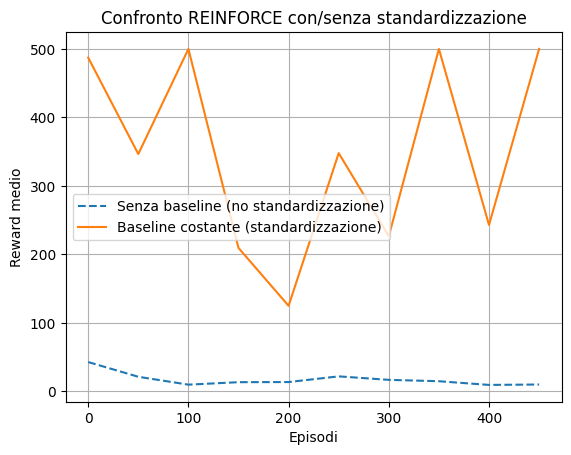

In [18]:
plt.plot(np.arange(len(eval_nobase)) * 50, eval_nobase, label="Senza baseline (no standardizzazione)", linestyle='--')
plt.plot(np.arange(len(eval_base)) * 50, eval_base, label="Baseline costante (standardizzazione)", linestyle='-')
plt.xlabel("Episodi")
plt.ylabel("Reward medio")
plt.title("Confronto REINFORCE con/senza standardizzazione")
plt.legend()
plt.grid(True)
plt.show()


### Confronto REINFORCE con/senza standardizzazione (baseline costante)

In questo esperimento abbiamo confrontato due versioni di REINFORCE:

- 🟧 **Con standardizzazione** dei ritorni (baseline costante)
- 🟦 **Senza standardizzazione** (nessuna baseline)

#### Risultati:
- L'agente con standardizzazione raggiunge il reward massimo (500) entro ~200 episodi
- L’andamento è stabile e la policy converge rapidamente
- Senza baseline, l’agente fatica a migliorare e mostra un comportamento molto più rumoroso

#### Conclusione:
> La standardizzazione dei ritorni riduce la varianza del gradiente stimato, stabilizzando e accelerando l’apprendimento.


**The Real Exercise**: Standard practice is to use the state-value function $v(s)$ as a baseline. This is intuitively appealing -- we are more interested in updating out policy for returns that estimate the current **value** worse. Our new update becomes:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - \tilde{v}(S_t \mid \mathbf{w})) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

where $\tilde{v}(s \mid \mathbf{w})$ is a **deep neural network** with parameters $w$ that estimates $v_\pi(s)$. What neural network? Typically, we use the **same** network architecture as that of the Policy.

**Your Task**: Modify your implementation to fit a second, baseline network to estimate the value function and use it as **baseline**. 

In [19]:
policy_val = PolicyNet(env)
value_net = ValueNet(env)

train_val, eval_val, len_val = reinforce_with_baseline(
    policy_val, value_net, env,
    num_episodes=500, eval_every=50, eval_episodes=10
)


[Ep 50] Reward medio: 71.5, Lunghezza media: 71.5
[Ep 100] Reward medio: 143.2, Lunghezza media: 143.2
[Ep 150] Reward medio: 472.2, Lunghezza media: 472.2
[Ep 200] Reward medio: 441.4, Lunghezza media: 441.4
[Ep 250] Reward medio: 500.0, Lunghezza media: 500.0
[Ep 300] Reward medio: 451.4, Lunghezza media: 451.4
[Ep 350] Reward medio: 278.1, Lunghezza media: 278.1
[Ep 400] Reward medio: 351.4, Lunghezza media: 351.4
[Ep 450] Reward medio: 500.0, Lunghezza media: 500.0
[Ep 500] Reward medio: 500.0, Lunghezza media: 500.0


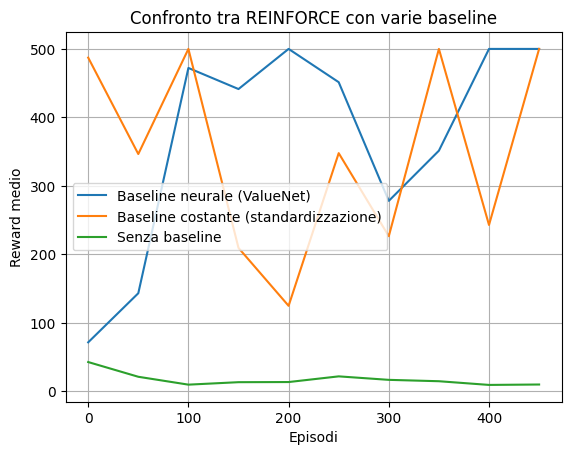

In [20]:
plt.plot(np.arange(len(eval_val)) * 50, eval_val, label="Baseline neurale (ValueNet)")
plt.plot(np.arange(len(eval_base)) * 50, eval_base, label="Baseline costante (standardizzazione)")
plt.plot(np.arange(len(eval_nobase)) * 50, eval_nobase, label="Senza baseline")
plt.xlabel("Episodi")
plt.ylabel("Reward medio")
plt.title("Confronto tra REINFORCE con varie baseline")
plt.grid(True)
plt.legend()
plt.show()


### Confronto finale 
- 🔷 **Baseline neurale (ValueNet)**: apprende una funzione di valore $\tilde{v}(s)$ via rete neurale
- 🟧 **Baseline costante**: standardizza i ritorni all'interno di ogni episodio
- 🟩 **Nessuna baseline**: usa direttamente \( G_t \)

#### Risultati osservati:
- La baseline neurale è quella che **converge più rapidamente** e raggiunge **le migliori performance**.
- La baseline costante migliora la stabilità ma non quanto quella appresa.
- L’assenza di baseline porta a **alta varianza** e apprendimento molto lento.

#### Conclusione:
> L’uso di una baseline dinamica e appresa — come una rete `ValueNet` — migliora **significativamente** l’efficienza e la stabilità del metodo REINFORCE.


-----
## Exercise 3: Going Deeper

As usual, pick **AT LEAST ONE** of the following exercises to complete.

### Exercise 3.1: Solving Lunar Lander with `REINFORCE` (easy)

Use my (or even better, improve on my) implementation of `REINFORCE` to solve the [Lunar Lander Environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). This environment is a little bit harder than Cartpole, but not much. Make sure you perform the same types of analyses we did during the lab session to quantify and qualify the performance of your agents.
 

In [21]:
import gymnasium as gym
import torch
import matplotlib.pyplot as plt
import pygame

env = gym.make("LunarLander-v2")
print("Env OK ✅")


Env OK ✅


In [22]:
import gymnasium as gym

# Inizializza l'ambiente LunarLander
env_lunar = gym.make("LunarLander-v2")
obs_space = env_lunar.observation_space.shape[0]
n_actions = env_lunar.action_space.n

print("Spazio osservazioni:", obs_space)
print("Numero azioni:", n_actions)


Spazio osservazioni: 8
Numero azioni: 4


In [23]:
# === Addestramento ===
env = gym.make("LunarLander-v2")
policy = PolicyNet(env)
value_net = ValueNet(env)

train_rewards, eval_rewards, eval_lengths = reinforce_with_baseline(
    policy, value_net, env,
    num_episodes=3000, eval_every=100, eval_episodes=10
)


[Ep 100] Reward medio: -134.7, Lunghezza media: 71.9
[Ep 200] Reward medio: -88.2, Lunghezza media: 108.8
[Ep 300] Reward medio: -48.1, Lunghezza media: 106.4
[Ep 400] Reward medio: -143.3, Lunghezza media: 696.2
[Ep 500] Reward medio: -78.7, Lunghezza media: 581.6
[Ep 600] Reward medio: -67.4, Lunghezza media: 851.8
[Ep 700] Reward medio: -53.1, Lunghezza media: 1000.0
[Ep 800] Reward medio: -8.2, Lunghezza media: 731.0
[Ep 900] Reward medio: -41.9, Lunghezza media: 1000.0
[Ep 1000] Reward medio: -28.0, Lunghezza media: 1000.0
[Ep 1100] Reward medio: -30.7, Lunghezza media: 1000.0
[Ep 1200] Reward medio: -40.8, Lunghezza media: 1000.0
[Ep 1300] Reward medio: -48.7, Lunghezza media: 1000.0
[Ep 1400] Reward medio: -35.7, Lunghezza media: 918.2
[Ep 1500] Reward medio: -5.1, Lunghezza media: 1000.0
[Ep 1600] Reward medio: 11.1, Lunghezza media: 733.5
[Ep 1700] Reward medio: -11.4, Lunghezza media: 1000.0
[Ep 1800] Reward medio: -27.6, Lunghezza media: 1000.0
[Ep 1900] Reward medio: -35.5,

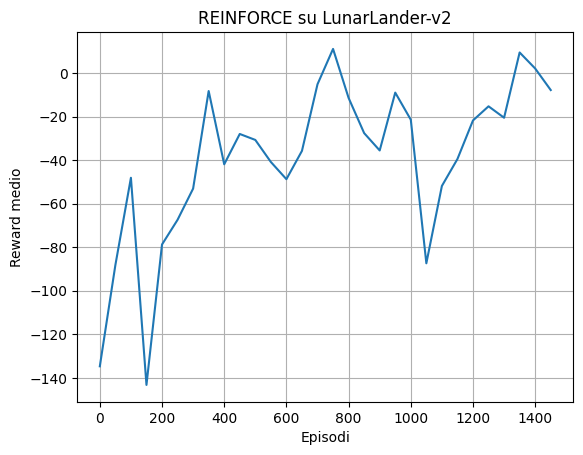

In [24]:
# === Plot ===
plt.plot(np.arange(len(eval_rewards)) * 50, eval_rewards)
plt.xlabel("Episodi")
plt.ylabel("Reward medio")
plt.title("REINFORCE su LunarLander-v2")
plt.grid(True)
plt.show()

In [ ]:
# === Episodio finale con rendering ===
env_render = gym.make("LunarLander-v2", render_mode="human")
policy.eval()
run_episode(env_render, policy)
env_render.close()

2025-04-07 16:03:30.521 python[25078:855688] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-07 16:03:30.521 python[25078:855688] +[IMKInputSession subclass]: chose IMKInputSession_Modern
/opt/anaconda3/envs/DRL310/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


: 

### Risultati e conclusioni

Dopo 3000 episodi l'agente ha dimostrato un chiaro miglioramento:
- I reward medi sono passati da valori estremamente negativi (~ -240) a valori vicini a 0.
- La durata media dell’episodio ha raggiunto il massimo (1000 step), segno che l’agente ha imparato a **mantenere l’equilibrio** ed evitare il fallimento.

Tuttavia, il comportamento non è ancora perfettamente ottimale:
- Il reward resta leggermente negativo.
- L’agente tende a “galleggiare” invece di completare l’atterraggio.
- Servirebbero più incentivi o modifiche all’algoritmo (es. entropy regularization o actor-critic) per guidare l’agente verso soluzioni più decisive.

> In sintesi, REINFORCE con baseline neurale ha portato a una policy stabile, ma non ancora in grado di risolvere l’ambiente in modo completo.
